In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


In [28]:
# Data: https://www.kaggle.com/datasets/denkuznetz/food-delivery-time-prediction/data
data = pd.read_csv('../data/Food_Delivery_Times.csv')


In [29]:
print("First few rows of the dataset and shape:")
print(data.shape)
data.head()

First few rows of the dataset and shape:
(998, 9)


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [30]:
print("\nNumber of duplicate rows:")
print(data.duplicated().sum())


Number of duplicate rows:
0


In [31]:
#drop oder ID
data = data.drop(columns=["Order_ID"])

# Relationships EDA

### 1. Distance_km vs. Delivery_Time_min


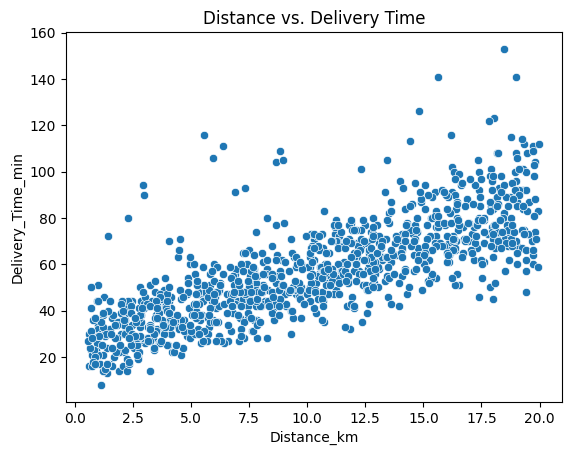

In [32]:
sns.scatterplot(x="Distance_km", y="Delivery_Time_min", data=data)
plt.title("Distance vs. Delivery Time")
plt.show()

### 2. Traffic_Level vs. Delivery_Time_min


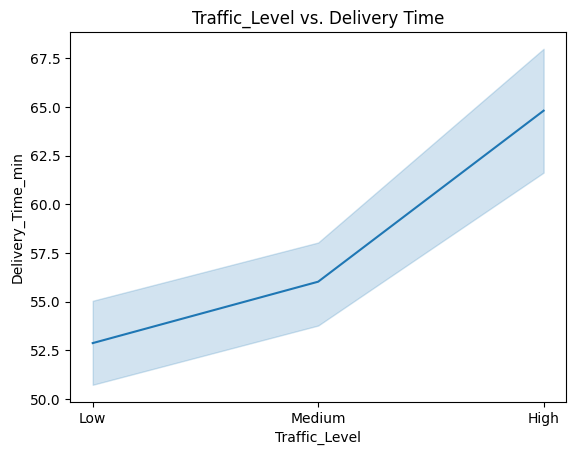

In [33]:
sns.lineplot(x="Traffic_Level", y="Delivery_Time_min", data=data)
plt.title("Traffic_Level vs. Delivery Time")
plt.show()

### 3. Weather vs. Delivery_Time_min


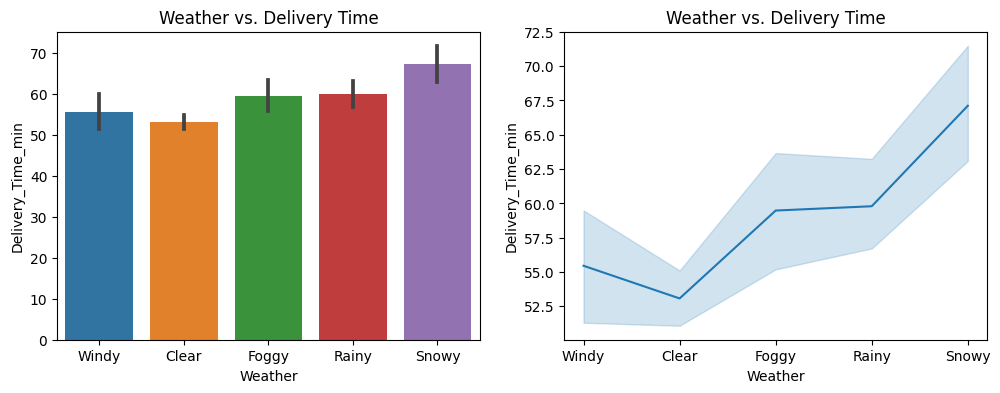

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.barplot(x="Weather", y="Delivery_Time_min", data=data)
plt.title("Weather vs. Delivery Time")

plt.subplot(1, 2, 2)
sns.lineplot(x="Weather", y="Delivery_Time_min", data=data)
plt.title("Weather vs. Delivery Time")
plt.show()

### 4. Time_of_Day vs. Delivery_Time_min


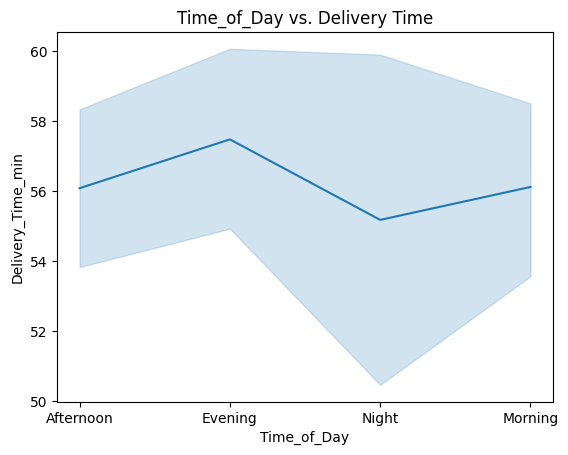

In [35]:
sns.lineplot(x="Time_of_Day", y="Delivery_Time_min", data=data)
plt.title("Time_of_Day vs. Delivery Time")
plt.show()

### 5. Vehicle_Type vs. Delivery_Time_min


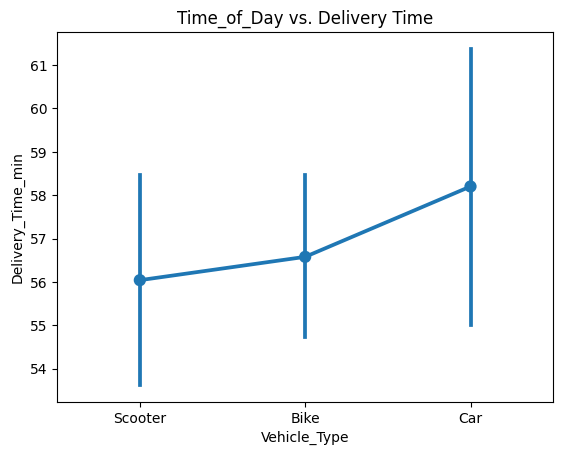

In [36]:
sns.pointplot(x="Vehicle_Type", y="Delivery_Time_min", data=data)
plt.title("Time_of_Day vs. Delivery Time")
plt.show()

### 6. Preparation_Time_min vs. Delivery_Time_min


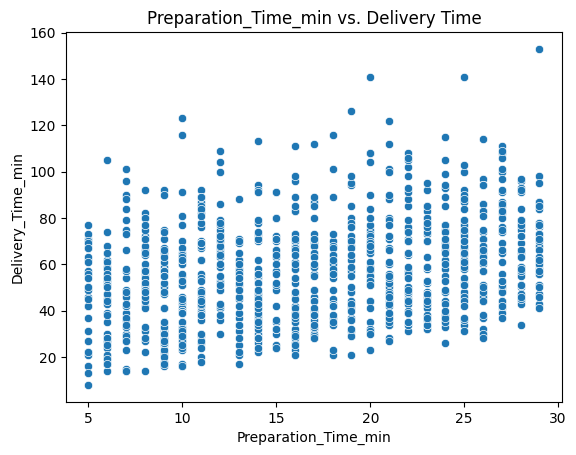

In [37]:
sns.scatterplot(x="Preparation_Time_min", y="Delivery_Time_min", data=data)
plt.title("Preparation_Time_min vs. Delivery Time")
plt.show()

### 7. Courier_Experience_yrs vs. Delivery_Time_min


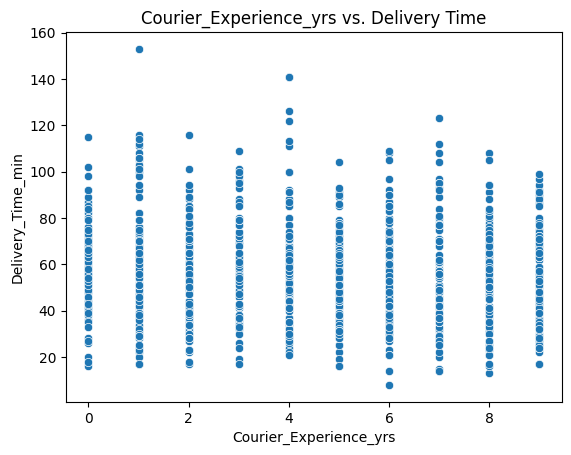

In [38]:
sns.scatterplot(x="Courier_Experience_yrs", y="Delivery_Time_min", data=data)
plt.title("Courier_Experience_yrs vs. Delivery Time")
plt.show()

### 8. Explore relationships between features and other features

Correlation Matrix:
                        Distance_km  Preparation_Time_min  \
Distance_km                1.000000             -0.007562   
Preparation_Time_min      -0.007562              1.000000   
Courier_Experience_yrs    -0.007018             -0.032404   
Delivery_Time_min          0.781439              0.307583   

                        Courier_Experience_yrs  Delivery_Time_min  
Distance_km                          -0.007018           0.781439  
Preparation_Time_min                 -0.032404           0.307583  
Courier_Experience_yrs                1.000000          -0.090659  
Delivery_Time_min                    -0.090659           1.000000  


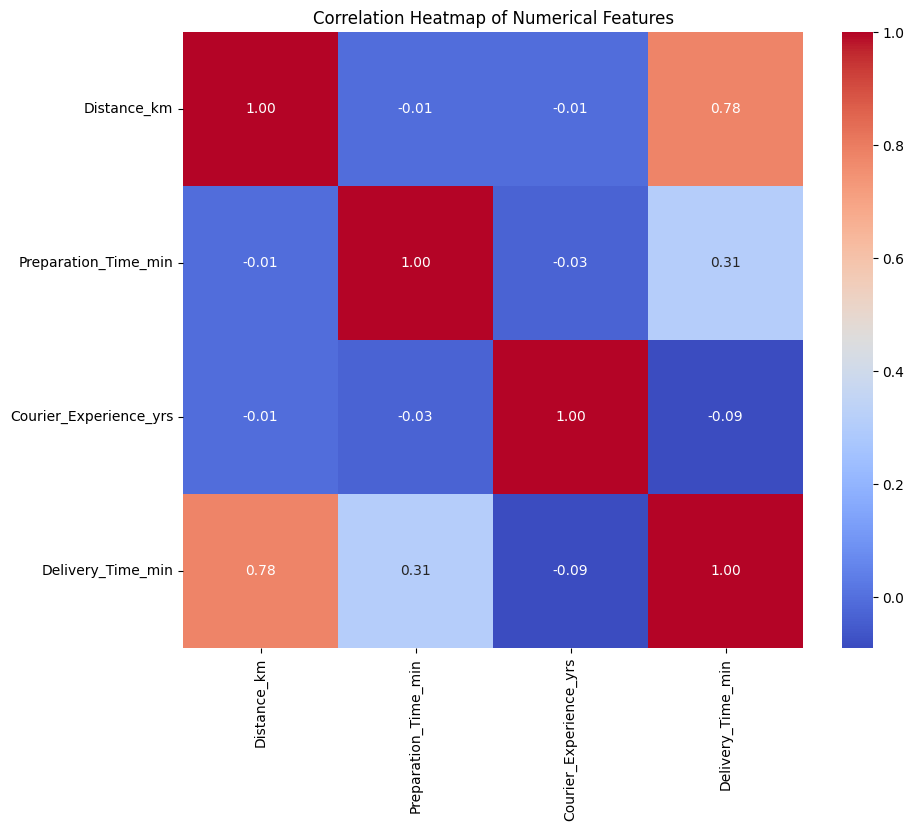

In [39]:
numerical_features = data.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_features.corr()

print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# ML we predict coz we have the target varibale (Delivery Time)

### Preprocessing 

In [40]:
data = pd.read_csv('../data/Food_Delivery_Times.csv')

print("Dataset Shape:", data.shape)
print("\nFirst 5 Rows:")
display(data.head())

print("\nMissing Values:")
print(data.isnull().sum())

print("\nDuplicate Rows:", data.duplicated().sum())

# Drop unnecessary columns
data = data.drop(columns=["Order_ID"])


Dataset Shape: (998, 9)

First 5 Rows:


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68



Missing Values:
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

Duplicate Rows: 0


### Feature Engineering (Without Data Leakage)

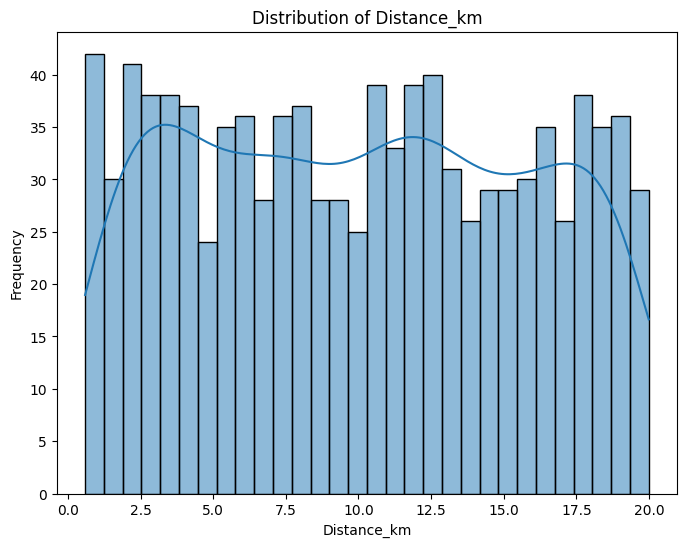

Skewness of Distance_km: 0.038996084455524715


In [41]:
# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(data['Distance_km'], kde=True, bins=30)
plt.title('Distribution of Distance_km')
plt.xlabel('Distance_km')
plt.ylabel('Frequency')
plt.show()

from scipy.stats import skew

# Calculate skewness
skewness = skew(data['Distance_km'])
print(f"Skewness of Distance_km: {skewness}")

Interpretation of Skewness
Skewness = 0: Perfectly symmetrical distribution.

Skewness > 0: Positively skewed (right-skewed).

Skewness < 0: Negatively skewed (left-skewed).

Skewness of Distance_km: 0.038996084455524715

No need to apply a log transformation because the data is already symmetrical.

Text(0.5, 1.0, 'Peak Hours vs Delivery Time')

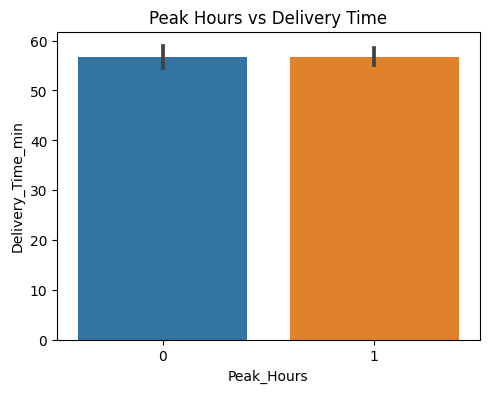

In [42]:

# 1. Peak_Hours: Identify peak hours without using target variable
data["Peak_Hours"] = data["Time_of_Day"].apply(lambda x: 1 if x in ["Morning", "Evening"] else 0)

# Visualize new features
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.barplot(x="Peak_Hours", y="Delivery_Time_min", data=data)
plt.title("Peak Hours vs Delivery Time")


### Separate features and target


In [43]:
X = data.drop(columns=["Delivery_Time_min"])
y = data["Delivery_Time_min"]

### Define categorical and numerical columns


In [44]:
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nNumerical Features:", numerical_columns)
print("Categorical Features:", categorical_columns)


Numerical Features: ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Peak_Hours']
Categorical Features: ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']


### Preprocessing Pipeline


In [45]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

### Train-Test Split


#### Here, 80% of the data is used for training, and 20% is held out for testing.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Model Pipeline Definitions
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVM": SVR(kernel="rbf"),
    "KNN": KNeighborsRegressor(),
    "Lasso": Lasso(alpha=0.01, random_state=42)
}

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(preprocessor.fit_transform(X_train), y_train)

print("\nBest Random Forest Parameters:", grid_search.best_params_)

# Update Random Forest with best parameters
models["Random Forest"] = grid_search.best_estimator_


Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


### Model Evaluation


Linear Regression Results:
CV RMSE: 10.54
Test RMSE: 10.97, R²: 0.75, MAE: 6.81

Decision Tree Results:
CV RMSE: 15.94
Test RMSE: 19.34, R²: 0.23, MAE: 12.88

Random Forest Results:
CV RMSE: 11.38
Test RMSE: 11.44, R²: 0.73, MAE: 7.72

SVM Results:
CV RMSE: 12.90
Test RMSE: 12.69, R²: 0.67, MAE: 8.29

KNN Results:
CV RMSE: 12.99
Test RMSE: 13.69, R²: 0.61, MAE: 9.55

Lasso Results:
CV RMSE: 10.54
Test RMSE: 10.97, R²: 0.75, MAE: 6.80


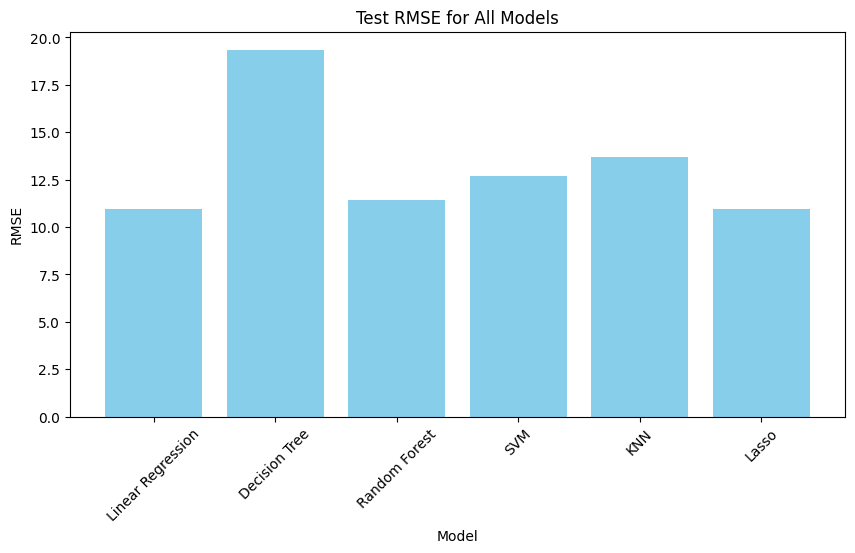


------------------Best Model------------: Lasso


In [48]:
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Cross-validation
    # Here, the training set (X_train, y_train) is split into 5 folds for cross-validation.
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {
        "CV RMSE": cv_rmse,
        "Test RMSE": rmse,
        "R²": r2,
        "MAE": mae
    }
    
    print(f"\n{name} Results:")
    print(f"CV RMSE: {cv_rmse:.2f}")
    print(f"Test RMSE: {rmse:.2f}, R²: {r2:.2f}, MAE: {mae:.2f}")

# Visualize Results
model_names = list(results.keys())
test_rmse = [results[name]["Test RMSE"] for name in model_names]

plt.figure(figsize=(10, 5))
plt.bar(model_names, test_rmse, color='skyblue')
plt.title("Test RMSE for All Models")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

# Determine the best model based on Test RMSE
best_model_name = min(results, key=lambda x: results[x]["Test RMSE"])
print(f"\n------------------Best Model------------: {best_model_name}")